In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

import xgboost as xgb

from scipy.stats import randint

import seaborn as sns

<h1>Data Cleaning and Preprocessing</h1>

In [2]:
# Load dataset
dataset = pd.read_csv('Survival_Data.csv')

In [3]:
#Drop undesired features
dataset = dataset.drop(['studyid', 'site', 'strength_comfort_religion', 'petition_prayer_health', 'intercessory_prayers_health'], axis = 1)

In [4]:
# Separate the dataset into numerical and categorical features
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = dataset.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

In [5]:
# Use median imputation on the numerical features for missing values
dataset[numerical_features] = dataset[numerical_features].fillna(dataset[numerical_features].median())

# Use mode imputation on the categorical features for missing values
for col in categorical_features:
    dataset[col] = dataset[col].fillna(dataset[col].mode().iloc[0])

In [ ]:
# Convert binary categorical variables ('Yes'/'No') into 1/0
binary_columns = [col for col in categorical_features if dataset[col].nunique() == 2]
for col in binary_columns:
    unique_values = dataset[col].unique()
    if set(unique_values) == {'Yes', 'No'}:
        dataset[col] = dataset[col].replace({'Yes': 1, 'No': 0})
    elif set(unique_values) == {'Not impaired', 'Impaired'}:
        dataset[col] = dataset[col].replace({'Impaired': 1, 'Not impaired': 0})
    else:
        mapping = {unique_values[0]: 1, unique_values[1]: 0}
        dataset[col] = dataset[col].map(mapping)


# Remaining categorical variables (multi-category)
multi_category_columns = [col for col in categorical_features if col not in binary_columns]

In [7]:
# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(dataset[multi_category_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(multi_category_columns))

In [8]:
# Drop original categorical columns and merge encoded ones
dataset = dataset.drop(multi_category_columns, axis=1)
dataset = pd.concat([dataset, encoded_categorical_df], axis=1)

# Fix special column (< causes issues)
dataset = dataset.rename(columns={
    'agecat_>=55-<65': 'agecat_55_to_65',
    'agecat_>=65': 'agecat_65_plus'
})

In [9]:
# Separate features and target
X = dataset.drop('died_2_year', axis=1)
y = dataset['died_2_year']

In [10]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

<h1>Basic Training Model Architecture</h1>

In [17]:
class ModelTrainer:
    def __init__(self, test_size=0.1, val_size=0.1):
        self.test_size = test_size
        self.val_size = val_size
        
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = self.split()
        self.models = {}

    def split(self):
        X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=(self.test_size + self.val_size), stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def train_model(self, model_name, model, param_grid=None, search_type='grid', cv_folds=5):
        """Train a model with optional hyperparameter tuning."""
        if param_grid:
            search_cv = GridSearchCV if search_type == 'grid' else RandomizedSearchCV
            model = search_cv(model, param_grid, cv=StratifiedKFold(n_splits=cv_folds), scoring='accuracy', n_jobs=-1, verbose=1)
            model.fit(self.X_train, self.y_train)
            model = model.best_estimator_
            best_params = {k: v for k, v in model.get_params().items() if v is not None}
            print(f"Best Parameters for {model_name}: {best_params}")
        else:
            model.fit(self.X_train, self.y_train)
        
        self.models[model_name] = model
        self.evaluate_model(model_name)
    
    def evaluate_model(self, model_name):
        """Evaluate the model using accuracy and confusion matrix."""
        model = self.models[model_name]
        y_train_pred = model.predict(self.X_train)
        y_val_pred = model.predict(self.X_val)
        y_test_pred = model.predict(self.X_test)

        train_acc = accuracy_score(self.y_train, y_train_pred)
        val_acc = accuracy_score(self.y_val, y_val_pred)
        test_acc = accuracy_score(self.y_test, y_test_pred)

        print(f"\n=== {model_name} Performance ===")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print("\nClassification Report:\n", classification_report(self.y_test, y_test_pred))

        self.plot_confusion_matrix(self.y_test, y_test_pred, model_name)
    
    def plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {title}')
        plt.show()

<h1>Model Comparisons</h1>

In [18]:
trainer = ModelTrainer()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 99, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

=== Random Forest Performance ===
Train Accuracy: 0.9649
Validation Accuracy: 0.9372
Test Accuracy: 0.9517

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       195
           1       1.00      0.17      0.29        12

    accuracy                           0.95       207
   macro avg       0.98      0.58      0.63       207
weighted avg       0.95      0.95      0.94       207



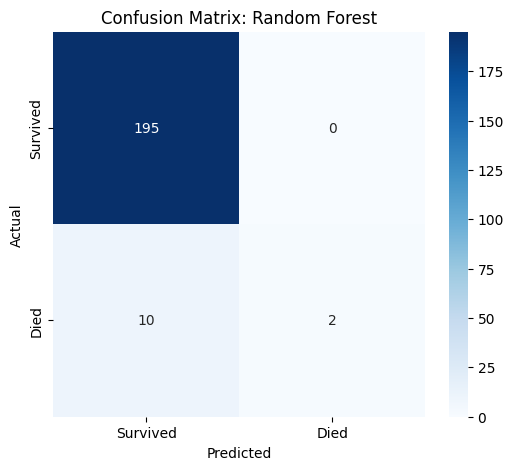

In [22]:
# RandomForest Classfier
rf_params = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(3, 7),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(5, 20),
}
trainer.train_model("Random Forest", RandomForestClassifier(random_state=42), param_grid=rf_params, search_type='random')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for XGBoost: {'objective': 'binary:logistic', 'enable_categorical': False, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 5, 'missing': nan, 'n_estimators': 100, 'random_state': 42}

=== XGBoost Performance ===
Train Accuracy: 0.9692
Validation Accuracy: 0.9614
Test Accuracy: 0.9758

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       195
           1       1.00      0.58      0.74        12

    accuracy                           0.98       207
   macro avg       0.99      0.79      0.86       207
weighted avg       0.98      0.98      0.97       207



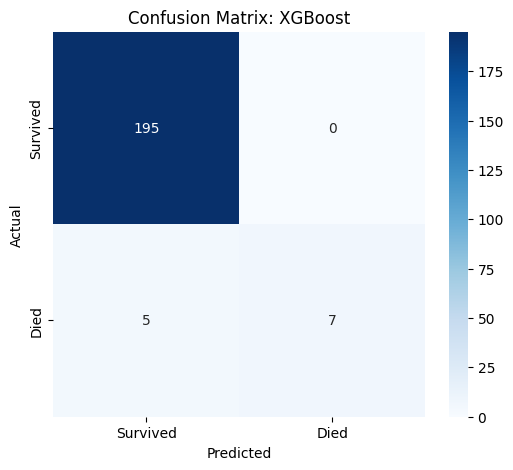

In [21]:
# XG Boost
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
}
trainer.train_model("XGBoost", xgb.XGBClassifier(random_state=42, eval_metric="logloss"), param_grid=xgb_params)

In [ ]:
# Logistic Regression
trainer.train_model("Logistic Regression", LogisticRegression(penalty='l2', random_state=42))

In [ ]:
# Simple Vector Machine
trainer.train_model("SVM", SVC(random_state=42))